# Bi-linear interaction model with group-by augmentations

## Prepare dataset for training

Following the same steps as in [the training of a simple model](https://github.com/tinyclues/recsys-multi-atrribute-benchmark/blob/master/training/movielens%20simple%20model.ipynb), we first load splitted dataset generated in [notebook](https://github.com/tinyclues/recsys-multi-atrribute-benchmark/blob/master/dataset_preprocessing/movielens%20with%20imdb.ipynb)

In [1]:
import os
import tensorflow as tf

from utils import DATASETS_ROOT_DIR

datasets = {}
for split_name in ['train', 'val', 'test']:
    path = os.path.join(DATASETS_ROOT_DIR, f'movielens_imdb/aggregated_{split_name}_dataset.tf')
    datasets[split_name] = tf.data.experimental.load(path, compression="GZIP")

2023-02-21 10:55:15.764758: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-21 10:55:15.928102: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2023-02-21 10:55:15.928139: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-21 10:55:17.078785: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


2023-02-21 10:55:18.421028: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:
2023-02-21 10:55:18.421096: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-21 10:55:18.421161: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (35b5250889ca): /proc/driver/nvidia/version does not exist
2023-02-21 10:55:18.421450: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other 

Then we parse features' names to obtain a list of offer features (that will be used to modelize film) and a list of user features (aggregated history up to chosen date)

In [2]:
from utils import AGG_PREFIX

all_columns = list(datasets['train'].element_spec.keys())
technical_columns = ['userId', 'date']
user_features = list(filter(lambda x: x.startswith(AGG_PREFIX), all_columns))
offer_features = list(filter(lambda x: x not in user_features + technical_columns, all_columns))

### Rebatching datasets

Splitting dataset into smaller batches in the same way as described in [the training of a simple model](https://github.com/tinyclues/recsys-multi-atrribute-benchmark/blob/master/training/movielens%20simple%20model.ipynb)

In [3]:
%%time

from functools import partial
from uuid import uuid4

from utils import rebatch_by_events

datasets['train'] = rebatch_by_events(datasets['train'], batch_size=10080, date_column='date', nb_events_by_user_by_day=8)
for key in ['val', 'test']:
    datasets[key] = rebatch_by_events(datasets[key], batch_size=50400, date_column='date', nb_events_by_user_by_day=8,
                                      seed=1729).cache(f'/tmp/{uuid4()}.tf')

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
CPU times: user 49.7 s, sys: 8.33 s, total: 58 s
Wall time: 43.7 s


In [31]:
from utils import add_equal_weights

for key in datasets:
    datasets[key] = datasets[key].map(partial(add_equal_weights, features=offer_features))

## Define the model

First we need to get number of different modalities inputs can take from saved vectorizers (it will be used in embeddings layer definition):

In [4]:
from utils import load_inverse_lookups
inverse_lookups = load_inverse_lookups(os.path.join(DATASETS_ROOT_DIR, 'movielens_imdb/inverse_lookups.pickle'))

In [5]:
import re

vocabulary_sizes = {}

for feature in offer_features:
    vocabulary_sizes[feature] = inverse_lookups[feature].vocabulary_size()

for feature in user_features:
    for key in inverse_lookups:
        pattern = re.compile(r"{}(\w+)_{}".format(AGG_PREFIX, key))
        if pattern.match(feature):
            vocabulary_sizes[feature] = vocabulary_sizes[key]

### Layers definitions

To define a model with group-by augmentations we need to create some layers described in article (TODO link). In all following schemas we color weights that will be learned during training in red.

#### Generation of group-by augmentations

To get group-by augmentations we need first choose randomly some offer features we will use to get group by keys that will consist of AND and OR combinations of values from chosen features. It is implemented in `KeyGenerator` layer. Next once we get keys, we will group by and calculate mean and variance embeddings vectors for other features wrt to chosen keys. Finally, we will broadcast mean and variance vectors back to return to original batch size. Both calculation and broadcast are implemented in `GroupBy` layer.

<img src="resources/group_by_augmentation.png" alt="group-by augmentation generation" width="800" />

In [6]:
from layers import KeyGenerator, GroupBy

In [7]:
test_key_generator = KeyGenerator(number_of_offer_attributes=len(offer_features),
                                  average_number_of_attributes_in_key=2,
                                  name='test_key_generator')

In [8]:
# sampling randomly values for offer features
test_offer_features = tf.random.uniform((10, len(offer_features)), maxval=5, dtype=tf.int32)
test_offer_features

<tf.Tensor: shape=(10, 7), dtype=int32, numpy=
array([[1, 2, 4, 1, 1, 1, 3],
       [3, 4, 1, 2, 0, 4, 3],
       [3, 1, 1, 0, 0, 1, 0],
       [0, 0, 1, 2, 4, 2, 2],
       [0, 3, 3, 1, 3, 3, 0],
       [2, 3, 2, 3, 3, 1, 2],
       [2, 2, 2, 4, 1, 1, 3],
       [3, 2, 4, 1, 3, 0, 1],
       [1, 1, 1, 2, 0, 2, 2],
       [2, 3, 1, 2, 1, 3, 0]], dtype=int32)>

In [9]:
# key generator returns hashed keys for group by
test_keys = test_key_generator(test_offer_features)
test_keys

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([1, 1, 1, 0, 1, 0, 1, 0, 0, 1], dtype=int32)>

In [10]:
group_by = GroupBy(name='group_by')

In [11]:
# if we have some embeddings vectors
test_embeddings = tf.random.normal((10, 3))

In [12]:
# we can apply group-by operation for all features
test_mean, test_var = group_by(test_keys, test_embeddings)
test_mean.shape, test_var.shape

(TensorShape([10, 3]), TensorShape([10, 3]))

In [13]:
# or more direct example of group by
import numpy as np
group_by([0, 0, 1], np.eye(3))

(<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
 array([[0.5, 0.5, 0. ],
        [0.5, 0.5, 0. ],
        [0. , 0. , 1. ]])>,
 <tf.Tensor: shape=(3, 3), dtype=float64, numpy=
 array([[0.25, 0.25, 0.  ],
        [0.25, 0.25, 0.  ],
        [0.  , 0.  , 0.  ]])>)

#### Compression of user features

For optimisation of calculation of interaction we want to reduce number of user features we use. For that we will generate meta features using a sequence of fully connected layers based on `tf.keras.layers.experimental.EinsumDense` layer.

<img src="resources/user_features_compression.png" alt="compression of user features" width="800" />

In [14]:
from layers import UserFeaturesCompressor
test_user_compressor = UserFeaturesCompressor(number_of_meta_features=2,
                                              dropout_rate=0.1,
                                              name='test_user_compressor')
test_user_compressor(tf.random.normal((10, 3, 7))).shape

TensorShape([10, 2, 7])

#### Compression of offer features and MaskNet

This is a key layer that will create some meta offer features and apply instance guided mask over embedding dimension. For meta features, the idea is similar to user side: we want to get smaller number of features before interaction, but here using information about variance we can completely deactivate some features, depending on offer we want to predict.

<img src="resources/offer_features_compression.png" alt="compression of offer features" width="800" />

In [15]:
from layers import OfferFeaturesCompressor
test_offer_compressor = OfferFeaturesCompressor(number_of_meta_features=2,
                                                dropout_rate=0.1,
                                                name='test_offer_compressor')
test_offer_compressor([tf.random.normal((10, 3, 7)), tf.random.normal((10, 3, 7))]).shape

TensorShape([10, 2, 7])

In [16]:
from layers import MaskNet
test_mask = MaskNet(number_of_meta_features=2, dropout_rate=0.1)
test_mask([tf.random.normal((10, 3, 7)), tf.random.normal((10, 3, 7))]).shape

TensorShape([10, 2, 7])

#### Bi-linear feature-wise interaction

Last step is a calculation of interaction using bi-linear kernel for each pair of meta features from user and from offer:

<img src="resources/bi_linear_interaction.png" alt="bi-linear feature wise interaction" width="800" />

In [18]:
# TODO describe mini batch negative generation

In [21]:
from layers import BiLinearInteraction
test_interaction = BiLinearInteraction(number_of_negatives=3, dropout_rate=0., name='test_interaction')
test_interaction([tf.random.normal((10, 4, 7)), tf.random.normal((10, 3, 5))], generate_negatives=False).shape

TensorShape([10, 12])

In [22]:
test_interaction([tf.random.normal((12, 4, 7)), tf.random.normal((12, 3, 5))], generate_negatives=True).shape

TensorShape([48, 12])

### Model architecture

Now we can assemble all these layers into final model. Note that offer compression weights and interaction kernels are shared between different augmentations we generate.

<img src="resources/bi_linear_augmentation_model.png" alt="model" width="800" />

### Model parameters

TODO describe tuning choices

In [27]:
EMBEDDING_DIM = 30
L1_COEFF = 1e-6
DROPOUT = 0.05
NB_AUGMENTATIONS = 3
AVERAGE_NUMBER_OF_FEATURES_IN_AUGMENTATION = 2
USER_META_FEATURES = 5
OFFER_META_FEATURES = 3

def REGULARIZER():
    return {'class_name': 'L1L2', 'config': {'l1': L1_COEFF, 'l2': 0.}}

def OUTPUT_DNN():
    return tf.keras.Sequential([
        tf.keras.layers.Dropout(DROPOUT),
        tf.keras.layers.Dense(20, activation='gelu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(20, activation='gelu'),
        tf.keras.layers.Dropout(DROPOUT),
        tf.keras.layers.Dense(1),
    ])

EPOCHS = 5

NUMBER_OF_NEGATIVES = 4
LOSS = tf.keras.losses.BinaryCrossentropy(from_logits=True)
AUC_METRIC = tf.keras.metrics.AUC(from_logits=True)

import tensorflow_addons as tfa
OPTIMIZER = tfa.optimizers.AdamW(weight_decay=1e-8, learning_rate=0.002)

### Embeddings

We will define embeddings with the same `WeightedEmbeddings` layer described in [the training of a simple model](https://github.com/tinyclues/recsys-multi-atrribute-benchmark/blob/master/training/movielens%20simple%20model.ipynb) with one addition:
* for offer features when aggregating a list of embedding vectors, we will also calculate variance and not only mean vector

It is easy to do in the same sparse-dense matrix multiplication operation as mean calculation (we get second moment and then calculate variance from it).

In [24]:
from layers import get_input_layer, WeightedEmbeddings
from utils import WEIGHT_SUFFIX

inputs = {}
embedded_user_features, embedded_offer_features, variance_offer_features = {}, {}, {}
for feature in user_features:
    inputs[feature] = get_input_layer(feature)
    emb_layer = WeightedEmbeddings(vocabulary_sizes[feature],
                                   EMBEDDING_DIM, name=f'{feature}_embedding',
                                   embeddings_regularizer=REGULARIZER())
    embedded_user_features[feature] = emb_layer(inputs[feature])
for feature in offer_features:
    # for offer features we need weights:
    # with dummy weights during training, and the ones used for a feature's averaging at inference time
    inputs[f'{feature}_weight'] = get_input_layer(f'{feature}_weight', tf.float32)
    inputs[feature] = get_input_layer(feature)
    emb_layer = WeightedEmbeddings(vocabulary_sizes[feature],
                                   EMBEDDING_DIM, name=f'{feature}_embedding',
                                   embeddings_regularizer=REGULARIZER(),
                                   calculate_variance=True)
    embedded_offer_features[feature], variance_offer_features[feature] = emb_layer(inputs[feature],
                                                                                   inputs.get(f'{feature}_weight'))

### Combining everything into model

Now we can define described model architecture on the top of embeddings.

In [25]:
user_stacked = tf.stack(list(embedded_user_features.values()), axis=1)
offer_stacked = tf.stack(list(embedded_offer_features.values()), axis=1)
offer_variance = tf.stack(list(variance_offer_features.values()), axis=1)
stacked_raw_offer_attrs = tf.stack([tf.cast(inp.values, tf.int32) for feature, inp in inputs.items()
                                    if feature in offer_features], axis=1)

In [26]:
stacked_raw_offer_attrs

<KerasTensor: shape=(None, 7) dtype=int32 (created by layer 'tf.stack_3')>

In [35]:
key_generator = KeyGenerator(number_of_offer_attributes=len(offer_features),
                             average_number_of_attributes_in_key=AVERAGE_NUMBER_OF_FEATURES_IN_AUGMENTATION,
                             name='grp_key_generator')

user_compressed = UserFeaturesCompressor(USER_META_FEATURES, DROPOUT,
                                         name='user_compressor')(user_stacked)
offer_features_compressor = OfferFeaturesCompressor(OFFER_META_FEATURES, DROPOUT, name='offer_compressor')
mask_net = MaskNet(OFFER_META_FEATURES, DROPOUT, name='mask_generation')
apply_mask = tf.keras.layers.Multiply(name='apply_mask')
bi_linear_interaction = BiLinearInteraction(number_of_negatives=NUMBER_OF_NEGATIVES, dropout_rate=DROPOUT,
                                            initializer='random_normal', regularizer=REGULARIZER(),
                                            name='interaction')
output_dnn = OUTPUT_DNN()

augmentation_predictions = []
for i in range(NB_AUGMENTATIONS):
    group_by_key = key_generator(stacked_raw_offer_attrs)
    mean_offer_emb, variance_offer_emb = group_by(group_by_key, offer_stacked)
    compressed_offer_embeddings = offer_features_compressor([mean_offer_emb, variance_offer_emb])
    mask = mask_net([mean_offer_emb, variance_offer_emb])
    masked_offer_embeddings = apply_mask([compressed_offer_embeddings, mask])
    _output = output_dnn(bi_linear_interaction([user_compressed, masked_offer_embeddings], generate_negatives=True))
    augmentation_predictions.append(_output)
output = tf.concat(augmentation_predictions, axis=1)

/opt/conda/lib/python3.7/site-packages/keras/initializers/initializers_v2.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  f"The initializer {self.__class__.__name__} is unseeded "


In [36]:
from utils import BroadcastLoss, BroadcastMetric

model = tf.keras.Model(inputs, output, name='group_by_augmentations')
model.compile(optimizer=OPTIMIZER,
              loss=BroadcastLoss(LOSS, NUMBER_OF_NEGATIVES),
              metrics=[BroadcastMetric(AUC_METRIC, NUMBER_OF_NEGATIVES)])

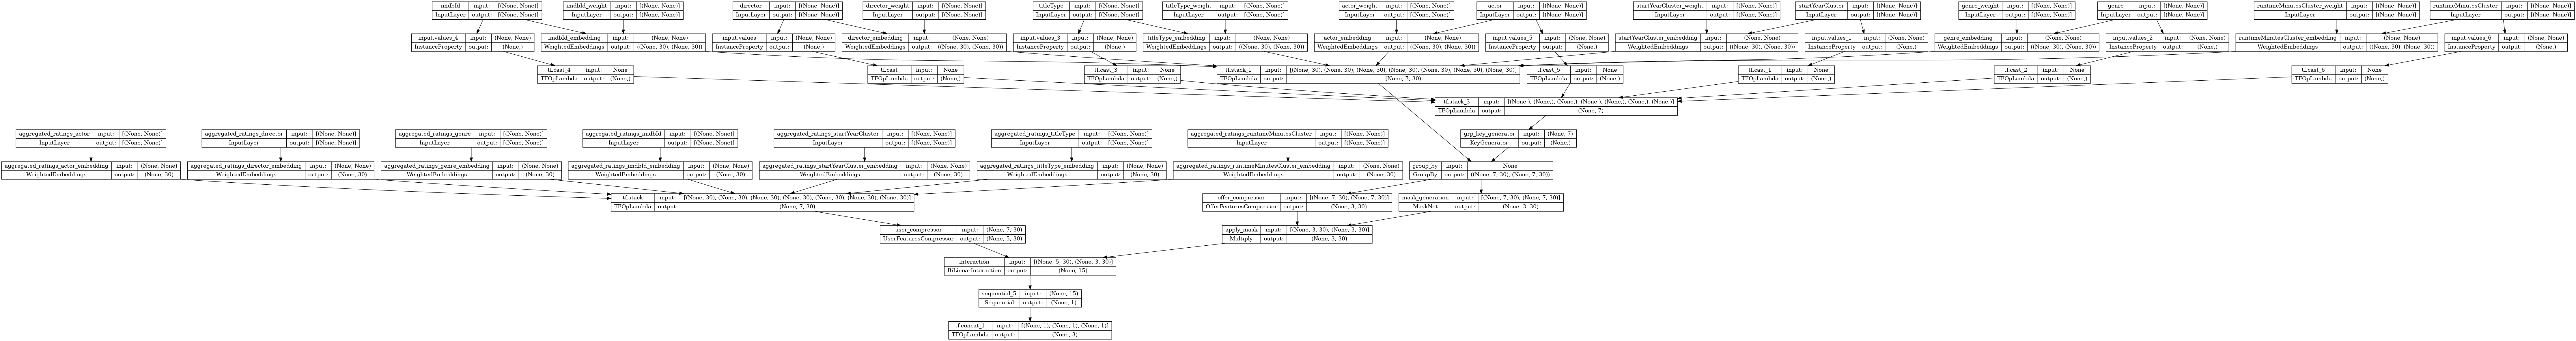

In [37]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='models/bi_linear_with_augmentations.png')

### Training

In [ ]:
model.fit(datasets['train'], epochs=1, validation_data=datasets['val'])